# Assigment 2

## The assignment is divided into programming and mathematical questions. Both of them are given in this notebook.

## Programming questions: I am giving you a template that you can use to write your code. Description of the questions is integrated in the comments.

## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [133]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize
from scipy.sparse.linalg import eigsh, spsolve
from scipy.sparse import linalg

# Numpy is useful for handling arrays and matrices.
import numpy as np
import random
import time

## Load image

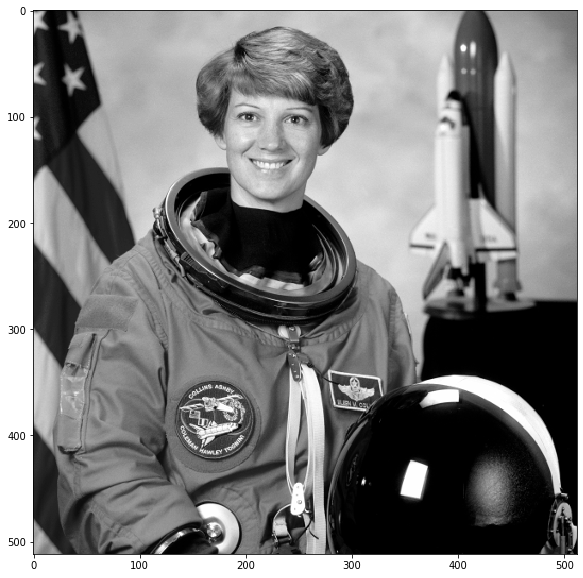

In [134]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 1.

In [135]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity

# Use your code from Assignment 1. 
# Make sure that you compute the right D_h and D_v matrices.
J = diags([1, -1], [0, 1], shape = (n, n)).tocsr()
I = identity(n).tocsr()
D_h = kron(J, I).tocsr()
D_v = kron(I, J).tocsr()

print('Done constructing the differences operators')
print('Dimensions:')
print('n^2:', n ** 2)
print('D_h:', D_h.shape)
print('D_v:', D_v.shape)

Done constructing the differences operators
Dimensions:
n^2: 262144
D_h: (262144, 262144)
D_v: (262144, 262144)


## Add noise to the image

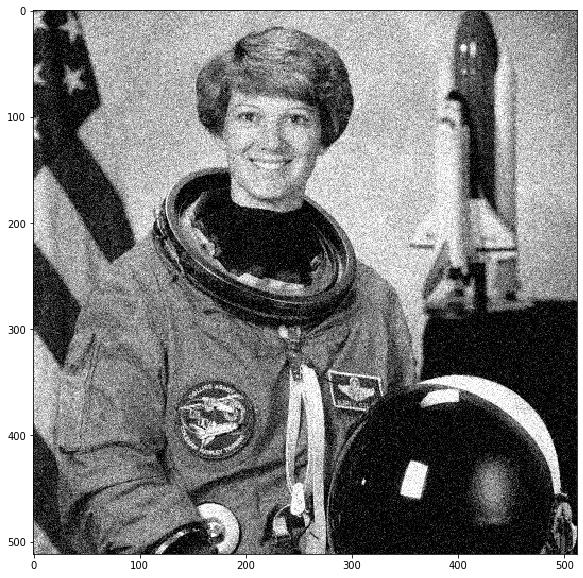

In [136]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

In [141]:
#Constants used throughout the assignment
I = identity(n * n).tocsr()
D = D_h + D_v * 1j
realD = D_h.transpose() * D_h + D_v.transpose() * D_v
z = np.reshape(noisy_image, (n * n, 1))

## Question 1: implement gradient descent using the Lipschitz constant as the step-size for the denoising problem. Use eigsh method from scipy.sparse.linalg to compute the Lipschitz constant. Marks: 10

In [172]:
def gradient_descent(x0, epsilon, lambda_, max_iterations):
    
# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.
    x = []
    xCurrent = x0
    x.append(xCurrent)
    
    A = lambda_ * realD + I
    eigenvalues = eigsh(A, k = 1, return_eigenvectors = False)
    L = eigenvalues[0] # takes 417.75706s to compute with L
    #L = 32.99969939193243 #takes 2.35956s to compute without having to calculate L
    
    for i in range(max_iterations):
        gradF = A * xCurrent - z
        xNext = xCurrent - gradF / L
        x.append(xNext)
        if (np.linalg.norm(gradF) < epsilon):
            return (xNext, x)
        else:
            xCurrent = xNext
    return (xNext, x)

## Call Gradient Descent

Time to calculate Gradient Descent with L: 417.7570641040802s


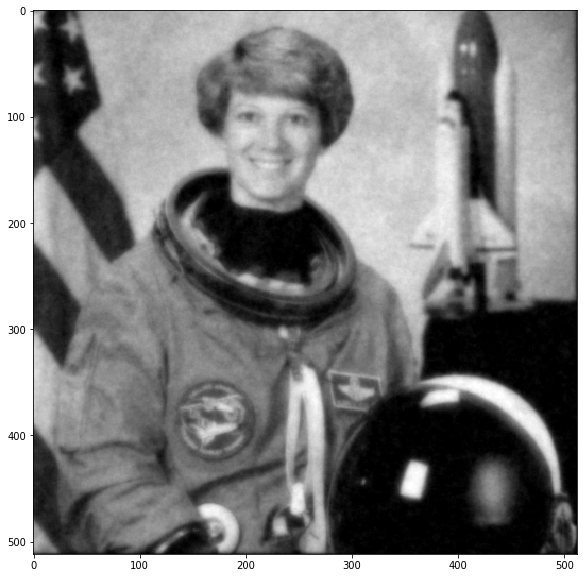

In [173]:
# Initialize parameters of gradient descent.
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.

x0 = np.reshape(noisy_image, (n * n, 1))

startTime = time.time()
x, allX = gradient_descent(x0, epsilon, lambda_, max_iterations)
endTime = time.time() - startTime

print('Time to calculate Gradient Descent with L: {}s'.format(endTime))

xImg = x.reshape(img.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(xImg, cmap='gray', vmin=0, vmax=255)
plt.show()

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

Iternations for Gradient Descent with L: 359


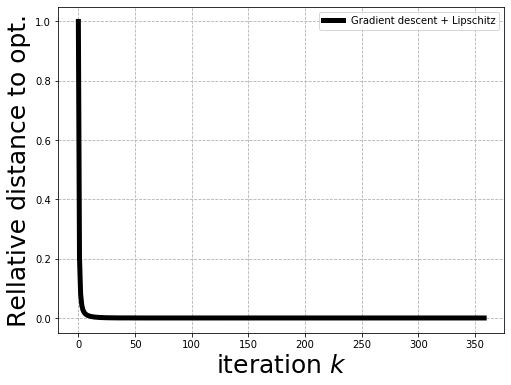

In [174]:
# Plot the rellative objective function vs number of iterations. 
# Write your code here.
store_data_for_plotting = []

fx0 = (lambda_ / 2) * (np.linalg.norm(D * x0) ** 2)
#f(x*)
A = lambda_ * realD + I
b = z
xStar = spsolve(A, b)
xStar = xStar.reshape((xStar.shape[0], 1))

fxStar = (lambda_ / 2) * (np.linalg.norm(D * xStar) ** 2) + 0.5 * np.linalg.norm(xStar - z) ** 2
denominator = fx0 - fxStar

for i in range (len(allX)):
    fxk = (lambda_ / 2) * (np.linalg.norm(D * allX[i]) ** 2) + 0.5 * np.linalg.norm(allX[i] - z) ** 2
    store_data_for_plotting.append((fxk - fxStar) / (denominator))

print('Iternations for Gradient Descent with L:', len(store_data_for_plotting))

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 10},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 2: is there a "gap" between the practical convergence rate and the theoretical convergence rate? Note that the denoising objective function is strongly convex. Marks: 5

The theoretical convergence rate is given by the equation: $(1 - \frac{\mu}{L}) ^ t$, where t is the number of iterations, L is the Lipschitz constant, and $\mu$ is a constant greater than 0, for which strong convexity holds. It is also the smallest eigen value of real(D*D)

To see if theoretical or practical is better, we will plot the above function and compare it to the plot we got for question 1. The plot is shown below:

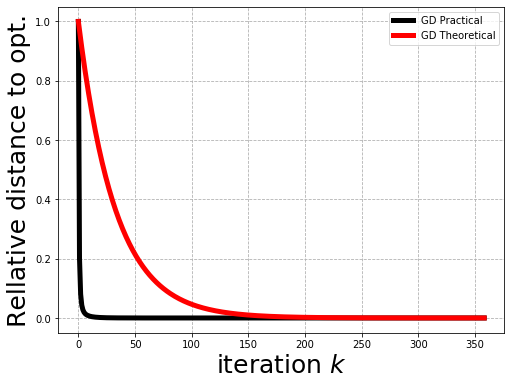

In [182]:
store_data_for_plotting_theoretical = []
mu = 1 
L = 32.99969939193243 #dont want to recalulate L for plotting

for t in range (len(store_data_for_plotting)):
    store_data_for_plotting_theoretical.append((1 - mu/L) ** t)

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("GD Practical"), linewidth=5.0, color ="black")
plt.plot(store_data_for_plotting_theoretical, label=("GD Theoretical"), linewidth=5.0, color ="red")
plt.legend(prop={'size': 10},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

So as we can see from the above graph that the red line, which corresponds to the theoretical convergence rate, takes more steps to get to the optimal solution, where as the practical one gets there faster.

## Question 3: implement gradient descent with line-search for the denoising problem. Marks: 15

In [175]:
# Write a line-search function here. 
# I am giving you a hint about what the input could be, but feel free to change the template. 
#def line_search(x, D, Dx, vec_image, grad_reg, grad_fit, lambda_):

def line_search(x, D, A, z, grad_reg, grad_fit, lambda_):
    
# D: represents the complex forward differences matrix from the Lecture notes.
# A: lambda * real(D*D) + I
# z: is the vectorized noisy image
# grad_reg: is the gradient of the regularization term ||Dx||_2^2
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_: is the regularization parameter of the denoising problem.

# Write your code here.
    alpha = 1
    fxk = (lambda_ / 2) * grad_reg + 0.5 * grad_fit
    gradFxk = A * x - z
    leftSide = x - alpha * gradFxk
    
    #f(xk - a*gradf(xk)):
    fLeftSide = (lambda_ / 2) * (np.linalg.norm(D * leftSide)) ** 2 + 0.5 * (np.linalg.norm(leftSide - z)) ** 2
    
    while (fLeftSide > fxk):
        alpha = alpha / 2
        leftSide = x - alpha * gradFxk
        fLeftSide = (lambda_ / 2) * (np.linalg.norm(D * leftSide)) ** 2 + 0.5 * (np.linalg.norm(leftSide - z)) ** 2

    return alpha

# Write gradient descent + line-search here.
# I am giving you a hint about what the input could be, but feel free to change the template. 
def gradient_descent(x0, epsilon, lambda_, max_iterations):

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.

    x = []
    xCurrent = x0
    x.append(xCurrent)
    A = lambda_ * realD + I
    
    for i in range (max_iterations):
        gradF = A * xCurrent - z
        Dx = D * xCurrent
        grad_reg = np.linalg.norm(Dx) ** 2
        grad_fit = np.linalg.norm(xCurrent - z) ** 2
        
        alpha = line_search(xCurrent, D, A, z, grad_reg, grad_fit, lambda_)
        xNext = xCurrent - alpha * gradF
        x.append(xNext)
        
        if (np.linalg.norm(gradF) < epsilon):
            return (xNext, x)
        else:
            xCurrent = xNext
    return (xNext, x)       

## Call Gradient Descent with line-search

Time to calculate Gradient Descent with vanilla Line Search: 5.14098858833313s


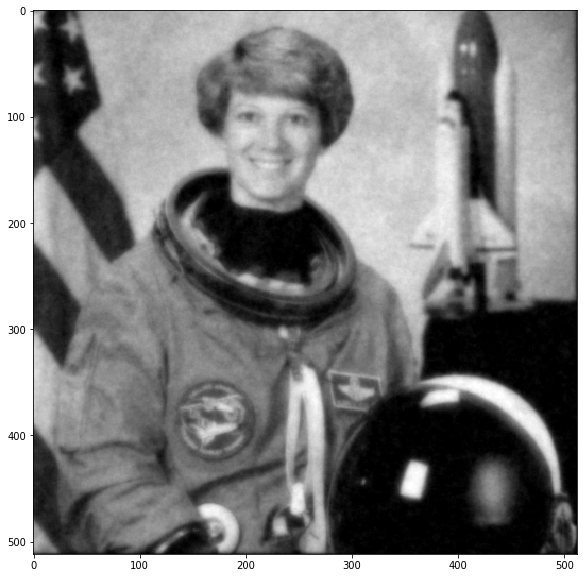

In [176]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.

startTime = time.time()
x, allXAlpha = gradient_descent(x0, epsilon, lambda_, max_iterations)
endTime = time.time() - startTime

print('Time to calculate Gradient Descent with vanilla Line Search: {}s'.format(endTime))

xImg = x.reshape(img.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(xImg, cmap='gray', vmin=0, vmax=255)
plt.show()

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

Iternations for Gradient Descent with vanilla Line Search 93


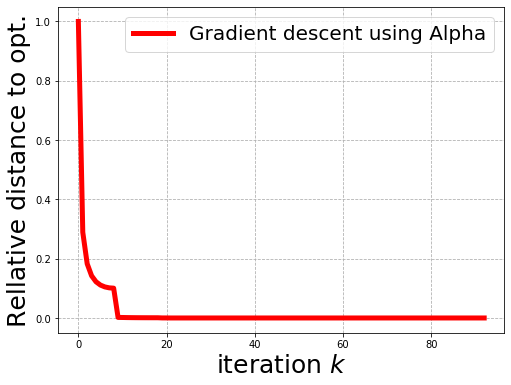

In [177]:
# Plot the rellative objective function vs number of iterations. 
# Write your code here.
# Here is an example code 

store_data_for_plotting_Alpha = []

fx0 = (lambda_ / 2) * (np.linalg.norm(D * x0) ** 2)
#f(x*)
A = lambda_ * realD + I
b = z
xStar = spsolve(A, b)
xStar = xStar.reshape((xStar.shape[0], 1))

fxStar = (lambda_ / 2) * (np.linalg.norm(D * xStar) ** 2) + 0.5 * np.linalg.norm(xStar - z) ** 2
denominator = fx0 - fxStar

for i in range (len(allXAlpha)):
    fxk = (lambda_ / 2) * (np.linalg.norm(D * allXAlpha[i]) ** 2) + 0.5 * np.linalg.norm(allXAlpha[i] - z) ** 2
    store_data_for_plotting_Alpha.append((fxk - fxStar) / (denominator))

print('Iternations for Gradient Descent with vanilla Line Search', len(store_data_for_plotting_Alpha)) 

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting_Alpha, label=("Gradient descent using Alpha"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 4: What is the advantage of using line-search to compute the step-size at each iteration instead of using constant step-sizes equal to 1/L? Where L is the Lipschitz constant. Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time when you add computation of the Lipschitz constant in the running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of number of required iterations? Marks: 10

$\textbf{Q}$: What is the advantage of using line-search to compute the step-size at each iteration instead of using constant step-sizes equal to 1/L?

$\textbf{A}$: The main advantage is that with line search, we do not have to compute L. Computing L takes a significant amount of time (almost 418 seconds), which can be avoided by using line search. Also, as shown along side the plots, line search takes significantly less iterations to find the optimal solution when compared to gradient descent using L (93 steps vs 359 steps recpectively).

$\textbf{Q}$: Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time?

$\textbf{A}$: Asuming we do not factor in the time taken to compute L, we can see (in the comments in the cell 172) that constant step-sizes takes about 2.34s to complete. In comparison, line search takes just over 5s. So it takes twice as long, which makes sense, since for line searh we have to compute D * x for each iteration, which is multiplying a $n^2$ x $n^2$ matrix with a column vector if $n^2$ items. So the run time for each iteration is $n^4$, and we are doing more calulations for line search, which has a time complexity of $O(log_2 L)$. And we do all of that k times for gradient descent. Where as in step-sizes, the most comlicated thing we are doing matrix multiplication for k iterations of gradient descent.

$\textbf{Q}$: Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time when you add computation of the Lipschitz constant in the running time?

$\textbf{A}$: Definately is. If you look at the time it took to compute Gradient Descent with L, which was almost 418 seconds, which is significantly larger than the 5 seconds it took line search. That is because it takes a significantly longer time (almost 416 seconds of the 418 seconds) to compute the eigenvalues of an $n^2$ x $n^2$ matrix. This time can be reduced if we use power iteration instead of eigsh to compute L.

$\textbf{Q}$: Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of number of required iterations?

$\textbf{A}$: Line search is a lot faster. If you look at the plots, we can see that step size takes almost 360 steps, where as line search terminates after 93 steps. which is almost 4 times less steps


## Questions 5: implement gradient descent with Armijo line-search for the denoising problem. Marks: 10

In [151]:
# Create a line-search function

#def line_search(x, D, Dx, vec_image, grad_reg, grad_fit, lambda_, gamma):
def line_search(x, D, A, z, grad_reg, grad_fit, lambda_, gamma):

# D: represents the complex forward differences matrix from the Lecture notes.
# A: lambda * real(D*D) + I.
# z: is the vectorized noisy image
# grad_reg: is the gradient of the regularization term ||Dx||_2^2
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_: is the regularization parameter of the denoising problem.
# gamma: parameter of Armijo line-search as was defined in the lectures.

# Write your code here.
    alpha = 1
    fxk = (lambda_ / 2) * grad_reg + 0.5 * grad_fit
    gradFxk = A * x - z
    gradFNormSq = np.linalg.norm(gradFxk) ** 2
    leftSide = x - alpha * gradFxk

    #f(xk - a*gradf(xk)):
    fLeftSide = (lambda_ / 2) * (np.linalg.norm(D * leftSide)) ** 2 + 0.5 * (np.linalg.norm(leftSide - z)) ** 2
    
    while(fLeftSide > fxk - alpha * gamma * gradFNormSq):
        alpha = alpha / 2
        leftSide = x - alpha * gradFxk
        fLeftSide = (lambda_ / 2) * (np.linalg.norm(D * leftSide)) ** 2 + 0.5 * (np.linalg.norm(leftSide - z)) ** 2
    
    return alpha

def gradient_descent(x0, epsilon, lambda_, max_iterations, gamma):

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# gamma: parameter of Armijo line-search as was defined in the lectures.

# Write your code here.

    x = []
    xCurrent = x0
    x.append(xCurrent) 
    A = lambda_ * realD + I
    
    for i in range (max_iterations):
        gradF = A * xCurrent - z
        Dx = D * xCurrent
        grad_reg = np.linalg.norm(Dx) ** 2
        grad_fit = np.linalg.norm(xCurrent - z) ** 2
        
        alpha = line_search(xCurrent, D, A, z, #L = 32.99969939193243grad_reg, grad_fit, lambda_, gamma)
        
        xNext = xCurrent - alpha * gradF
        
        x.append(xNext)
        if (np.linalg.norm(gradF) < epsilon):
            return (xNext, x)
        else:
            xCurrent = xNext
    return (xNext, x)

## Call Gradient Descent with Armijo line search

Time to calculate Gradient Descent with Armijo Line Search: 4.494313478469849s


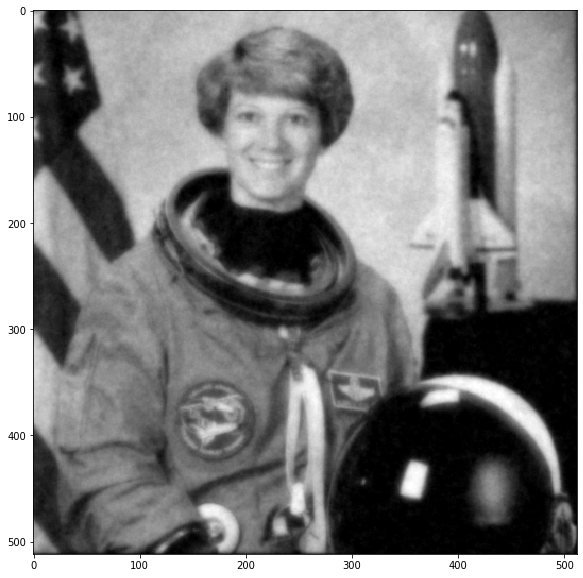

In [171]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
# gamma = random.uniform(0,0.5)
gamma = 0.14

startTime = time.time()
x, allXArmijo = gradient_descent(x0, epsilon, lambda_, max_iterations, gamma)
endTime = time.time() - startTime

print('Time to calculate Gradient Descent with Armijo Line Search: {}s'.format(endTime))

xImg = x.reshape(img.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(xImg, cmap='gray', vmin=0, vmax=255)
plt.show()

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

Iternations for Gradient Descent with vanilla Line Search 93
Iternations for Gradient Descent with Armijo Line Search 84


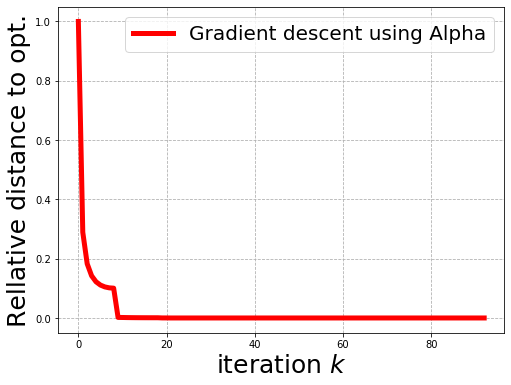

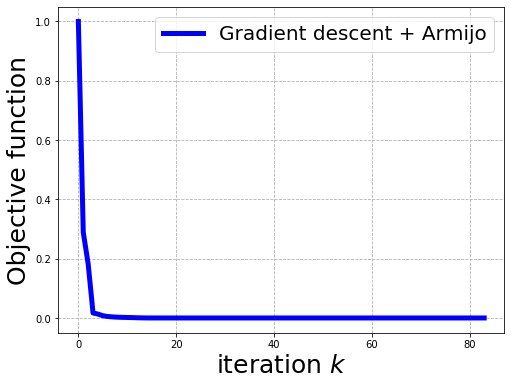

In [154]:
# Plot the rellative objective function vs number of iterations. 
# Write your code here.
# Here is an example code 

store_data_for_plotting_Armijo = []

fx0 = (lambda_ / 2) * (np.linalg.norm(D * x0) ** 2)
#f(x*)
A = lambda_ * realD + identity(n * n)
b = z
xStar = spsolve(A, b)
xStar = xStar.reshape((xStar.shape[0], 1))

fxStar = (lambda_ / 2) * (np.linalg.norm(D * xStar) ** 2) + 0.5 * np.linalg.norm(xStar - z) ** 2
denominator = fx0 - fxStar

for i in range (len(allXArmijo)):
    fxk = (lambda_ / 2) * (np.linalg.norm(D * allXArmijo[i]) ** 2) + 0.5 * np.linalg.norm(allXArmijo[i] - z) ** 2
    store_data_for_plotting_Armijo.append((fxk - fxStar) / (denominator))

print('Iternations for Gradient Descent with vanilla Line Search', len(store_data_for_plotting_Alpha)) 
print('Iternations for Gradient Descent with Armijo Line Search', len(store_data_for_plotting_Armijo))    

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting_Alpha, label=("Gradient descent using Alpha"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting_Armijo, label=("Gradient descent + Armijo"), linewidth=5.0, color ="blue")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 6: Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of running time? Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of number of required iterations? Explain any performance differences between the two approaches. Marks: 10

$\textbf{Q}$: Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of running time?

$\textbf{A}$: Since both have to do k iterations for gradient descent at worst, and both take $log_2 L$ time to compute alpha, and both has to multiply $n^2$ x $n^2$ matrix with a column vector of $n^2$ items, the time complexity of both should be roughly the same. This can be seen in the actual rin time of both functions. Line search takes about 5 seonds, while Armijo is about 0.5 seconds faster 

$\textbf{Q}$: Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of number of required iterations?

$\textbf{A}$: Yes it is faster. That is because we are subtracting an extra alpha * gamma * L2 Norm squared at each step, which allows us to get to the optimal solution faster. 

Since the termination criteria has an extra alpha gamma term that it checks for at each iteration, the function uses less steps to reach the convergence point and terminate

## Mathematical Questions

## Question 7: prove that the denoising objective function is strongly convex. What is its strong convexity parameter? Marks: 5

## Question 8: Prove that Armijo line-search will terminate after a finite number of steps. Hint: show that there exists a step-size $$\alpha^*>0$$ such that for any step-size smaller than $$\alpha^*$$ the termination condition of Armijo line-search is satisfied. How many iterations will be required in worst-case for Armijo line-search to terminate? Marks 15

## Question 9: what is the running time for gradient descent with Armijo line-search for the denoising problem to achieve $$f(x_k) - f^* \le \epsilon$$ ?. The running time is computed by multiplying the worst-case iteration complexity times the FLOPS at each iteration. The FLOPS at each iteration is the number of additions, subtractions, multiplications and divisions that are performed during the current iteration. 10

## Question 10: prove the convergence rate and iteration complexity for gradient descent with constant step-sizes (equal to 1/L) for strongly convex functions. Marks: 10